# Elastic weight consolidation- concept drift

In the past notebook *Triplet learning for bearing fault classification* we trained a classification model for bearing faults of rotating equipment. Such model was robust to different operating conditions such as different machine loads or rotation velocity, and did not use characteristic information about the machine, such as the rotation velocity or the characteristic coefficients. We used an approach based on triplet learning.

In this notebook, we want to illustrate how the retraining process would be done, when new data (from the same machine) arribes. Such new data may be slightly different from the data previously seen by the model, either because of concept drift or simply because we are seeing a common behaviour which had not been seen before. Therefore, we want the model to learn useful information of this new data without forgetting about the previously acquired knowledge.

In this notebook we will simulate concept drift, and see how the model adapts to this new situation. In the notebook *Elastic weight consolidation - new behaviour* we simulate the other situation, when the data changes only slightly. In order to simulate concept drift, we will use two different datasets: 

+ **Paderborn Data Center**: This dataset also contains vibration data (waveforms) of different bearings, each suffering from a fault (inner ring, outer ring) or being healthy. The fault is completely developed.This dataset will be considered as the *old* dataset.

+ **IMS Nasa Bearing Data Center:** This dataset contains the time evolution of different bearings. At the end of the tests, some of these bearings suffer from faults. The goal of using this dataset is to be able to detect failures at early stages, that is, before they have been fully developed. For this reason, the waveform time series will be labeled using the Autoencoder Model, so that waveforms with early development of the failure will be labeled as being unhealthy. We will use this data as the *new* data, when the concept drift has already happened. 

The inputs of the models will be the same as in the notebook *Triplet learning for bearing fault classification*.

More details about the training process are provided in the following sections.


The following lines of code are used to mount to drive account and import the needed packages.

In [1]:
#Import needed packages

import scipy.io
import scipy
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys
import tensorflow as tf
from tensorflow.keras import Model, layers
import pandas as pd
import umap
from sklearn.metrics import confusion_matrix, accuracy_score

sys.path.append('./Training')
sys.path.append('./Data')
sys.path.append('./Models')
sys.path.append('./Load_Data')

from IMS_data import Import_Data_IMS, Preprocessing_IMS
from Paderborn_data import Import_Data_Pad, Preprocessing_Pad, Load_Pad
from CNN_model import Embedding, Classification
from train_classifier import Training_classifier
from train_embeddings import Train_Embeddings
from pretraining import Pretraining
from EWC import Train_Classifier_EWC, Train_Embeddings_EWC,Fisher_matrix


In [2]:
print(tf.__version__)

2.1.0


## Load Paderborn data

Paderborn data contains time series of the vibration of rotating equipment (bearings). It contains two different rotation speeds (900 rpm and 1500 rpm). The dataset contains data from healthy bearings, and from two different types of faults: inner ring fault and outer ring fault. The faults are completely developed at the beginning of the time series.  


In [3]:
data_Pad = Import_Data_Pad('Data/Paderborn/K001/N15/', 'Data/Paderborn/K001/N09/', 'Data/Paderborn/KI01/N15/', 
                       'Data/Paderborn/KI01/N09/', 'Data/Paderborn/KA01/N15/', 'Data/Paderborn/KA01/N09/')

## Preprocessing

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Adding noise 

+ Shuffle samples.

+ Split of training and test sets.

The noise is introduced in two different ways:

+ Amplify the amplitude of the 4rth first harmonics.

+ Introduce white noise (random frequencies and amplitudes) within a frequency band of 750-1000Hz.

To visualize such noise, refer to the notebook *Elastic weight consolidation - new behaviour*.
We add noise so that the data resembles more to real data. 

### Preprocess Paderborn University Data

Given the file names of the data, the following class imports and processes the data in order to make it suitable for the CNN model. 

In [4]:
#Create preprocessing object
prep = Preprocessing_Pad()

#Load Paderborn data
load_Pad = Load_Pad(prep, data_Pad.healthy_files09, data_Pad.healthy_files15,data_Pad.inner_files09,
                     data_Pad.inner_files15,data_Pad.outer_files09, data_Pad.outer_files15)

X_train_Pad, X_test_Pad, y_train_Pad, y_test_Pad, load_train_Pad, load_test_Pad = load_Pad.get_X_y()

Data/Paderborn/K001/N09/N09_M07_F10_K001_1.mat


./Load_Data\Paderborn_data.py:253: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data_train = pd.concat([data_train, aux])
./Load_Data\Paderborn_data.py:255: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data_test = pd.concat([data_test, aux])


Data/Paderborn/K001/N09/N09_M07_F10_K001_10.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_11.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_12.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_13.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_14.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_15.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_16.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_17.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_18.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_19.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_2.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_20.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_3.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_4.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_5.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_6.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_7.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_8.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_9.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_1.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_10.mat
D

## Import IMS Data

We import the two files from the IMS Nasa Bearing Data Center. 
The datasets consist of two tests (Test1 and Test2), which contain the waveform time evolution of four bearings. Vibration data is collected with accelerometers. The bearings are of type Rexnord ZA-2115​.

The final state of each of the bearings is the following:

**Test1:**
+ Bearing 1 has an outer race defect which starts at around timestep 800
+ Bearing 2 is healthy
+ Bearing 3 is healthy
+ Bearing 4 has a rolling defect which starts at around timestamp 1800 

**Test2:**
+ Bearing 1 is healthy 
+ Bearing 2 is healthy
+ Bearing 3 has an inner race defect which starts at around timestep 1800
+ Bearing 4 is healthy


In the following class we will import the data from csv files and split it into four dataframes, one for each bearing.

In [5]:
test1 = Import_Data_IMS('Data/IMS/Test_1.csv')
test2 = Import_Data_IMS('Data/IMS/Test_2.csv')

The following lines of code put split the data into being healthy or having a fault (inner ring fault, outer ring fault and rolling element fault). In order to do wo, we use the labels obtained from the Autoencoder model, which tell us approximately in which timestamp the errors start their development.

In [6]:
#Define unhealthy data using the labels from the autoencoder model
inner = test1.t_2[1800:,:]
outer = test2.t_0[800:,:]
rolling = test1.t_3[1800:,:]

#For the healthy data, use waveforms from all tests
#We use a balanced dataset for healthy/unealthy data
idx = np.random.choice(np.arange(1300),70)
healthy1 = test1.t_2[idx,:]
idx = np.random.choice(np.arange(1300),70)
healthy2 = test1.t_3[idx,:]
idx = np.random.choice(np.arange(300),70)
healthy3 = test2.t_0[idx,:]

#Finally, concatenate all the healthy data
healthy  = np.concatenate([healthy1,healthy2,healthy3])

## Preprocessing IMS Data

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Shuffle samples.

+ Split of training and test sets.

In [7]:
prep_IMS = Preprocessing_IMS(inner, outer, rolling, healthy)

X_train_IMS, X_test_IMS, y_train_IMS, y_test_IMS = prep_IMS.get_X_y()


This is the code to load the embedding and classification models from the path where the weights are saved.

In [8]:
def load_model(filepath, learning_rate = 0.001, net = 'classification'):
    """
    Loads the embedding and classification models.
    Args:
        filepath (str): Path of the saved weights
        learning_rate (float): Learning rate of the Adam optimizer
    Returns:
        embedding (Model): Embedding model
        classification (Model): Classification model
    """
    #Redefine model
    embedding = Embedding()
    classification = Classification(embedding)

    optimizer = tf.optimizers.Adam(learning_rate)
    if net=='classification':
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=classification)
        manager = tf.train.CheckpointManager(ckpt, directory = filepath , max_to_keep=3)
        ckpt.restore(manager.latest_checkpoint)
        embedding = classification.embedding
    else:
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=embedding)
        manager = tf.train.CheckpointManager(ckpt, directory = filepath , max_to_keep=3)
        ckpt.restore(manager.latest_checkpoint)
        
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return embedding, classification

# Example of use:
# embedding, classification = load_model("Weights/TL/classifier/training/", learning_rate = 0.0001 )

## Pretraining: Simple CNN

We start by pre training the CNN with cross entropy loss, because it is a very stable loss function. This pre trained model will be used later to train the embeddings and the final classification model. 

We first define the hyperparameters: learning rate, training iterations, batch size, input size of the CNN, number of classification outputs.


In [11]:
# Parameters
learning_rate = 0.0001
training_iters = 150
batch_size = 16
display_step = 10
filepath = "Weights/EWC/Pad-IMS/classifier/pretraining/"

# Network Parameters
n_input = 1000 # Length of input data
num_classes = 4  # number of classes


### Embeddings

Next, we define the structure of the embedding network:

It consists of a 1D neural network, with the input the temporal series (waveform). 

The CNN has 3 1D Convolutional layers with 32,32 and 64 filters respectively, height=10, strides=4 and padding='same'. We have 3 MaxPooling subsampling layers with pool size = 10, strides = 4. Then we have 2 FC with 32 nodes, and another with 20 output nodes. This last layer is the output of the embedding- All layers have Relu activation function. This embedding will be used later on to classify the faults into different faults.

### Classification model

The classification model takes as input the output of the embedding model, and adds 3 Fc layers, with 64, 64 and 32 filters each. The output is the number of types of defects (4). During the pretraining process, all layers will be trained using cross entropy loss.

You can omit next cell and load the save weights directly.

In [13]:
# Build neural network model.
embedding = Embedding()
conv_net = Classification(embedding)

pretrain = Pretraining(conv_net, learning_rate, training_iters, batch_size, display_step,filepath, restore=False)

pretrain.fit(X_train_Pad, y_train_Pad, save=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 10, loss: 1.361948, accuracy: 0.437500
step: 20, loss: 1.339885, accuracy: 0.500000
step: 30, loss: 1.277514, accuracy: 0.750000
step: 40, loss: 1.272324, accuracy: 0.437500
step: 50, loss: 1.208798, accuracy: 0.500000
step: 60, loss: 1.182407, accuracy: 0.625000
step: 70, loss: 1.146564, accuracy: 0.625000
step: 80, loss: 1.286399, accuracy: 0.312500
step: 90, loss: 1.134626, accuracy: 0.562500
step: 100, loss: 1.168085, accuracy: 0.625000
step: 110, loss: 1.102629, accuracy: 0.812500
step: 120, 

In [9]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/EWC/Pad-IMS/classifier/pretraining/")

# Test model on validation set.
pred= conv_net(X_test_Pad)
emb = embedding(X_test_Pad)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_Pad))

Restored from Weights/EWC/Pad-IMS/classifier/pretraining/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing

This ends the pretraining phase. We observe that we have obtained an accuracy of 0.90, which will be improved by training the embeddings with triplet loss. 

## Triplet loss

Here we define the functions that will be used to compute the triplet loss of the embeddings. We use online triplet mining, with both 'batch all' and 'batch hard' strategies. 

For more information about triplet loss, refer to the notebook *Triplet learning for bearing fault classification*.



## Training Triplet loss

Now that we have a good initialization for the Weights from the pretrained model, we perform triplet loss optimization of the embeddings. 

We first define the hyperparameters for this part: learning rate, training iterations, batch size, margin, triplet strategy, embedding size and input size.  

You can skip these three cells and load directly the saved weights. 


In [10]:
# Parameters
learning_rate = 0.0001
training_iters = 50
batch_size = 64

#Triplet parameters
margin = 1.0
squared=False
triplet_strategy= 'batch_all'
filepath = "Weights/EWC/Pad-IMS/embedding/"

# Network Parameters
n_input = 1000 # Length of input data
embedding_size = 20 # length of embedding features 


In [18]:
#Function to get batches
def get_all_batches(data,labels,batch_size):
  '''
  Gets all the batches from existing dataset.

  Args:
    data (numpy array): X data
    labels (numpy array): y data
    batch_size (int): Batch size

  Returns:
    batches_x (list of numpy array): list of batches for X data
    batches_y (list of numpy array): list of batches for y data
    num_batches (int): Number of batches
  '''
  idx = np.arange(0,data.shape[0])
  np.random.shuffle(idx)

  data_shuffle = data[idx,:]
  labels_shuffle = labels[idx]

  labels_shuffle = labels_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size]
  data_shuffle = data_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size,:]
  
  num_batches = data_shuffle.shape[0]/batch_size 
  batches_x =np.split(data_shuffle,num_batches)
  batches_y =np.split(labels_shuffle,num_batches)

  return batches_x,batches_y,num_batches


We train the embeddings using triplet loss.

In [30]:
_,_,num_batches = get_all_batches(X_train_Pad,y_train_Pad,batch_size)
print(num_batches*training_iters)

train_emb = Train_Embeddings(embedding, learning_rate, int(num_batches*training_iters),
                             batch_size, display_step, triplet_strategy, margin, 
                             squared, filepath, restore=False)

train_emb.fit(X_train_Pad, y_train_Pad, save=False)

900.0
step:  10 Loss 0.50422466 Fraction positive triplets 0.009341253
step:  20 Loss 0.44714245 Fraction positive triplets 0.019443942
step:  30 Loss 0.48731408 Fraction positive triplets 0.029292094
step:  40 Loss 0.61029047 Fraction positive triplets 0.018208342
step:  50 Loss 0.7752452 Fraction positive triplets 0.014164867
step:  60 Loss 0.53884 Fraction positive triplets 0.016198045
step:  70 Loss 0.4249631 Fraction positive triplets 0.0037630536
step:  80 Loss 0.16261636 Fraction positive triplets 0.0010281386
step:  90 Loss 0.3114167 Fraction positive triplets 0.003457217
step:  100 Loss 0.3327564 Fraction positive triplets 0.0011699065
step:  110 Loss 0.49655762 Fraction positive triplets 0.015997117
step:  120 Loss 0.47886065 Fraction positive triplets 0.005943162
step:  130 Loss 0.58597267 Fraction positive triplets 0.0086269
step:  140 Loss 0.28610748 Fraction positive triplets 0.002339813
step:  150 Loss 0.2268829 Fraction positive triplets 0.0029175521
step:  160 Loss 0.3

In [11]:
# Comment this line to use the model you just trained and 
embedding, conv_net = load_model("Weights/EWC/Pad-IMS/embedding/", net="emb")

emb2 = embedding(X_test_Pad)

Restored from Weights/EWC/Pad-IMS/embedding/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



We visualize the embeddings using UMAP.  For  more information about UMAP see the notebook *Siamese network ofr bearing fault classification*.

C:\Users\laia.domingo.colomer\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


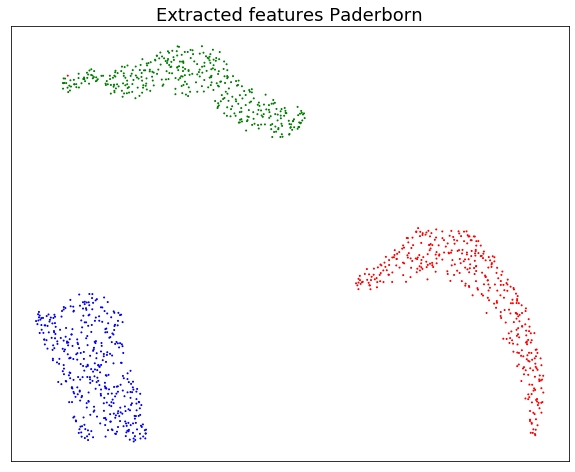

In [12]:
features = emb2

embed= umap.UMAP(n_neighbors=100,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_Pad,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features Paderborn", fontsize=18)

plt.show()


We can see that the embeddings are far apart for different failures, and close together for the same failure.

Now we compute the embeddings for the IMS data set.

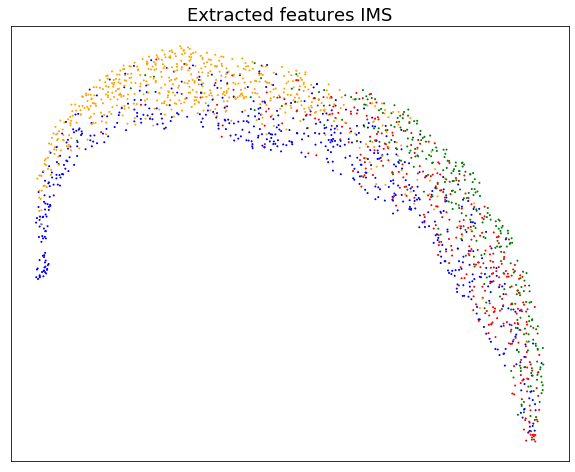

In [13]:
emb = embedding(X_test_IMS)

features = emb

embed= umap.UMAP(n_neighbors=100,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_IMS,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features IMS", fontsize=18)

plt.show()


## Classification model using triplet loss embeddings

Now that we have trained the embeddings using triplet loss, we will train the classifier using cross entropy loss. During this training the embedding layers will be frozen.



In [55]:
#Parameters
num_classes = 4
batch_size= 64
training_iters=200
learning_rate =0.0001
filepath = "Weights/EWC/Pad-IMS/classifier/training/"

In [56]:
# Build neural network model.
classifier = Training_classifier(conv_net, learning_rate, training_iters, batch_size, display_step, filepath, restore=False)

classifier.fit(X_train_Pad, y_train_Pad)

step: 10, loss: 0.774755, accuracy: 1.000000
step: 20, loss: 0.763366, accuracy: 1.000000
step: 30, loss: 0.753875, accuracy: 1.000000
step: 40, loss: 0.749617, accuracy: 1.000000
step: 50, loss: 0.748159, accuracy: 1.000000
step: 60, loss: 0.752161, accuracy: 1.000000
step: 70, loss: 0.763001, accuracy: 0.984375
step: 80, loss: 0.749763, accuracy: 1.000000
step: 90, loss: 0.746223, accuracy: 1.000000
step: 100, loss: 0.749516, accuracy: 1.000000
step: 110, loss: 0.745420, accuracy: 1.000000
step: 120, loss: 0.747463, accuracy: 1.000000
step: 130, loss: 0.745546, accuracy: 1.000000
step: 140, loss: 0.746108, accuracy: 1.000000
step: 150, loss: 0.746910, accuracy: 1.000000
step: 160, loss: 0.745138, accuracy: 1.000000
step: 170, loss: 0.745334, accuracy: 1.000000
step: 180, loss: 0.745409, accuracy: 1.000000
step: 190, loss: 0.746383, accuracy: 1.000000
step: 200, loss: 0.744639, accuracy: 1.000000
Saved checkpoint for step Weights/EWC/Pad-IMS/classifier/training/ckpt-1


We check the final accuracy in the IMS dataset

In [14]:
# Comment this line to use the model you just trained and 
embedding, conv_net = load_model("Weights/EWC/Pad-IMS/classifier/training/")

# Test model on test set.
pred= conv_net(X_test_IMS)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_IMS))

Restored from Weights/EWC/Pad-IMS/classifier/training/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test Accuracy: 0.191281


In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_IMS, y_pred)

array([[350,   0,   0,   0],
       [589,   1,   0,   0],
       [305,   0,   0,   0],
       [590,   0,   0,   0]], dtype=int64)

Now we test the accuracy on Padeborn data

In [16]:
# Test model on test set.
pred= conv_net(X_test_Pad)
y_pred = np.argmax(pred.numpy(), axis=1)
print(confusion_matrix(y_test_Pad, y_pred))

print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_Pad))

[[399   0   1]
 [  0 400   0]
 [  0   0 400]]
Test Accuracy: 0.999167


We notice that the model has a bad accuracy for IMS data. 
If this data is thought as concept drift, or a behaviour that can happen, we want the model to capture both behaviours. For this reason, we will try Elastic weight consolidation approach.

## Elastic Weight Consolidation

The goal of this technique is to train a model to perform task B without forgetting about task A. In order to do so, we will add a weighted L2 regularization. We describe briefely the theory behind this technique:

We model the posterior log probability of the parameters given the two datasets using Bayes theorem:

$$ \log p(\theta|D_A,D_B ) = \log p(D_B|\theta) + \log p(\theta|D_A) - \log p(D_B|D_A)$$

The left hand side is the log likelihood of the final model (in oder words, the loss function we want to minimize), the right-hand term can be thought of as an adaptive elastic weight regularizer that tries to maintain knowledge of the first task.

The term $ \log p(D_B|\theta)$ is the loss function for task B, and the term $\log p(D_B|D_A)$ does not depend on $\theta$. We have to calculate $\log p(\theta|D_A)$. However, this term is intractable, in the sense that it is difficult to find a closed form. Assuming that $p(\theta|D_A)$ is smooth and with a peak at $\theta_A^*$ (the optimal weights of task A), we can approximate it with a normal distribution with mean $\theta_A^*$ and variance $\mathbb{1}_A$. This technique is called Laplace approximation. Refer to the Master Thesis pdf for more information about the derivation of the Laplace Approximation. The term $\mathbb{1}_A$ is the hessian matrix of $\log p(\theta|D_A)$ and it is called Fisher information matrix. Here we will do a further approximation by using only the diagonal terms of the Fisher information matrix, which we will denote as $\hat{\mathbb{1}}_A$. Finally, the loss function we will minimize is:


$$\mathcal{L}_{B|A}(\theta) = \mathcal{L}_B(\theta) + \lambda (\theta - \theta_A^*)^T \hat{\mathbb{1}}_A (\theta - \theta_A^*) $$

Where $\lambda$ is a parameter to control the importance to the regularization term. Since $\hat{\mathbb{1}}_A$ is a diagonal matrix, the previous expression can be written as

$$\mathcal{L}_{B|A}(\theta) = \mathcal{L}_B(\theta) + \lambda \sum_i [\hat{\mathbb{1}}_A]_{i} (\theta_i - \theta_{A_i}^*)^2 $$

Where the sum is over all the parameters of the network, and $[\hat{\mathbb{1}}_A]_{i}$ is the ith diagonal term of $F_A$. Finally, we need to define how to compute $[F_A]_{i}$:

$$[\hat{\mathbb{1}}_A]_{i} = \frac{1}{N} \sum_i \Big(\frac{\partial \mathcal{L}_A(x_{A_i}| \theta_A^*)}{\partial \theta_{A_i}}\Big)^2 $$

Where the sum is made over the samples of the dataset from task A.

With this information we have been able to train a model for task $B$ without forgetting about taks $A$. What happens if we want to learn task $C$ without forgetting about tasks A and B? Note that this will be the case in our setting, since the model will be updated when new data arribes and we do not want to forget about *all* the previously learnt tasks. In this case we just need to replace the fisher matrix by the one of tasks A and B.  That is:

$$\mathcal{L}_{C|A,B}(\theta) = \mathcal{L}_C(\theta) + \lambda \sum_i[\hat{\mathbb{1}}_{A,B}]_i (\theta_i - \theta_{{A,B}_i}^*)^2 $$

That is, the optimal parameters $\theta_{{A,B}_i}^*$ are the ones obtained after applying EWC to task B, and the new Fisher information matrix is the one obtained after training both tasks (A and B). This process can be extended for many tasks, just by updating theFisher information matrix.

**Error in EWC**

EWC gives a way to approximate the posterior probability $p(\theta|D_A, D_B)$, but it does not say anything about the quality of this approximation. The sources of error in EWC are the following:

+ **Laplace Approximation**: It is used to approximate $p(\theta|D_A)$ by using the second  order Taylor expansion. The Laplace approximation has formally proven to be correct at the limit of large data sets. The Bernstein-von Mises theorem proves this fact when the model is regular, the prior probability density function is smooth and the sample size n is large.

+ **Diagonalization of Fisher information matrix (FIM)**: Instead of considering the whole FIM, only the diagonal components are taken into account. Although there are not clear error bounds for this approximation, if the matrix is diagonally-dominant, the approximated matrix contains the most relevant terms of the original matrix. Since the FIM is the Hessian matrix of $ f(\theta) = -log(p(\theta | D_A))$ around $\theta_A^*$, and $f(\theta)$ is concave around its maximum $\theta_A^*$, the FIM is positive definite and therefore diagonally-dominant. 

For more information about the Errors in EWC, refer to the Master Thesis pdf.

**References:**


+ Kirkpatrick, James; Pascanu, Razvan; Rabinowitz, Neil; Veness, Joel; Desjardins, Guillaume; Rusu, Andrei A.; Milan, Kieran; Quan, John; Ramalho, Tiago; Grabska-Barwinska, Agnieszka; Hassabis, Demis; Clopath, Claudia; Kumaran, Dharshan; Hadsell, Raia. *Overcoming catastrophic forgetting in neural networks.* arXiv.org/1612.00796v2

+ Guillaume P. Dehaene.A deterministic and computable Bernstein-von Mises theo-rem. 2019. arXiv: 1904.02505

+ Ferenc Huszar. *Comment on "Overcoming catastrophic forgetting in NNs":Are multiple penalties needed?*.  URL: https://www.inference.vc/comment-on-overcoming-catastrophic-forgetting-in-nns-are-multiple-penalties-needed-2/.

##  Fisher information matrix for triplet loss

First we create a class that calculates the fisher matrix for an existing model.
We will define the two fisher matrices: for the embeddings (triplet loss) and the classifier (cross entropy loss). 

The fisher information matrix for the embeddings is a bit tricky, since we do not have a loss function for every sample of the dataset, but for every hard/semi-hard triplet. In order to speed up the computations, we will use the batch hard strategy to compute the loss for every hard triplet. We will sample a batch, calculate the hard loss for all the elements of the batch, slice the tensor to get the $ith$ element, calculate its loss function,get the gradients and append the square gradients to a list. 

We create a class to compute the fisher information matrix for both the Triplet loss (embeddings) and Cross entropy (classification) losses.

Now we calculate the fisher information matrix for both the embeddings (triplet loss) and the classifier (cross entropy loss).

You can skip all these cells (until the validation). The training of EWC may take some hours to finish.

In [0]:
#Triplet loss fisher matrix
conv_net.unfreeze()
fisher_matrix_TL =  Fisher_matrix(X_train_Pad, y_train_Pad, embedding, task = 'triplet loss', batch_size = 32,
                     triplet_strategy='batch_hard', margin=margin, squared = squared)

In [0]:
#Cross entropy loss fisher matrix
conv_net.freeze()

fisher_matrix_CL =  Fisher_matrix(X_train_Pad, y_train_Pad, conv_net, task = 'classsification')

Now we will train the embeddings with triplet loss and EWC and then the classifier with cross entropy and EWC.

## Triplet loss + EWC

In [0]:
training_iters = 1000
display_step=1
learning_rate = 0.0001
filepath ="Weights/EWC/Pad-IMS/fisher/embedding/"
lamb = 1000
int(num_batches*training_iters)

18000

In [0]:
conv_net.unfreeze()
train_emb_EWC = Train_Embeddings_EWC(embedding, fisher_matrix_TL , learning_rate, int(num_batches*training_iters),
                                     batch_size, display_step, "batch_all", margin, squared,lamb, filepath, restore=False)

idx = np.random.choice(X_test_Pad.shape[0], 500)
train_emb_EWC.fit(X_train_IMS, y_train_IMS, X_test_Pad[idx,:], y_test_Pad[idx], save=False)

step 1 loss 1.37866 fisher_loss 0 triplet loss 1.37866 l2_loss 0 fraction B 0.766808093 lossA 0.41639182 fraction A 0.000210272701
step 2 loss 1.17830491 fisher_loss 0.00327405916 triplet loss 1.17503083 l2_loss 0.000579645 fraction B 0.81277287 lossA 0.428887159 fraction A 0.000260513567
step 3 loss 1.14255285 fisher_loss 0.00970569346 triplet loss 1.13284719 l2_loss 0.00175813958 fraction B 0.813587189 lossA 0.548332691 fraction A 0.00114126818
step 4 loss 0.972041965 fisher_loss 0.0209718049 triplet loss 0.951070189 l2_loss 0.00360836252 fraction B 0.797840118 lossA 0.880504549 fraction A 0.0078730369
step 5 loss 0.903111756 fisher_loss 0.03609965 triplet loss 0.867012084 l2_loss 0.00603108294 fraction B 0.842161953 lossA 1.31802833 fraction A 0.0195279401
step 6 loss 0.842536 fisher_loss 0.0531547964 triplet loss 0.789381146 l2_loss 0.00894904416 fraction B 0.893650115 lossA 1.61867785 fraction A 0.0329302251
step 7 loss 0.905727267 fisher_loss 0.0716518536 triplet loss 0.834075391

We observe that at the end of embeddings training, the fraction of positive triplets is very low for both tasks (Paderborn and IMS). This means that the network has learnt to produce good embeddings for both datasets.

## Classifier EWC

Now try to train the classifier using EWC (without training the embeddings)

In [39]:
training_iters = 10000
learning_rate = 0.00001
print(int(num_batches*training_iters))
filepath ="Weights/EWC/Pad-IMS/fisher/classifier/"

180000


In [0]:
conv_net.freeze()
train_clas_EWC = Train_Classifier_EWC(conv_net,fisher_matrix_CL, learning_rate, int(num_batches*training_iters),
                                     batch_size, display_step,1.3e3, filepath, restore=False)

train_clas_EWC.fit(X_train_IMS, y_train_IMS, X_train_Pad, y_train_Pad, save=True)

step 16 loss 0.775520205 fisher_loss 0.00113950553 l2_loss 0.000137006646 accuracy B 0.795399189 accuracy A 0.983347237
step 32 loss 0.436623156 fisher_loss 0.00433566282 l2_loss 0.000538415 accuracy B 0.802977 accuracy A 0.985845149
step 48 loss 0.556738317 fisher_loss 0.00872853771 l2_loss 0.0011557024 accuracy B 0.808660328 accuracy A 0.984179854
step 64 loss 0.572201669 fisher_loss 0.0133826341 l2_loss 0.00193439797 accuracy B 0.811096072 accuracy A 0.981681943
step 80 loss 0.553531349 fisher_loss 0.0176187046 l2_loss 0.00278328103 accuracy B 0.814614356 accuracy A 0.979184031
step 96 loss 0.44560954 fisher_loss 0.0210323911 l2_loss 0.00363906147 accuracy B 0.820568323 accuracy A 0.974188149
step 112 loss 0.388815552 fisher_loss 0.0238844454 l2_loss 0.00452722609 accuracy B 0.825439811 accuracy A 0.973355532
step 128 loss 0.502016604 fisher_loss 0.0252305511 l2_loss 0.00527583621 accuracy B 0.829228699 accuracy A 0.969192326
step 144 loss 0.70135355 fisher_loss 0.0280521214 l2_loss

Finally, test the accuracy for both tasks

### Task A (Paderborn)

In [47]:
# Comment this line to use the model you just trained 
#embedding = Embedding()
#conv_net = Classification(embedding)

#pretrain = Pretraining(conv_net, learning_rate, training_iters, batch_size, 
#                       display_step,"Weights/EWC/Pad-IMS/fisher/classifier/", restore=True)
#embedding = conv_net.embedding

embedding, conv_net = load_model("Weights/EWC/Pad-IMS/fisher/classifier/v2/")
#embedding, _= load_model("Weights/EWC/Pad-IMS/fisher/embedding/", net ="emb")

#conv_net.embedding = embedding

Restored from Weights/EWC/Pad-IMS/fisher/classifier/v2/ckpt-1


In [48]:
# Test model on test set.
pred= conv_net(X_test_Pad)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_Pad))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test Accuracy: 0.737500


In [62]:
#embedding = Embedding()
#conv_net = Classification(embedding)

classifier = Pretraining(conv_net, 0.0001, 80, batch_size, 100, filepath, restore=False)

X_train = np.concatenate((X_train_Pad, X_train_IMS), axis=0)
y_train = np.concatenate((y_train_Pad, y_train_IMS), axis=0) 

classifier.fit(X_train, y_train, save =False)

In [63]:
# Test model on test set.
pred= conv_net(X_test_Pad)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_Pad))

pred= conv_net(X_test_IMS)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_IMS))

Test Accuracy: 0.828333
Test Accuracy: 0.881744



### Task B (IMS)

In [25]:
# Test model on test set.
pred= conv_net(X_test_IMS)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_IMS))

Test Accuracy: 0.901362


We observe that using the EWC the model has learnt fairly well to perform taks B and it has prevented it from completely forgetting task A. However, since the datasets were pretty different, the accuracy on task A has decreased a bit.

Finally, we visualize the embeddings for both datasets.

### Task A (Paderborn)

In [79]:
emb_Pad = np.nan_to_num(embedding(X_test_Pad))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



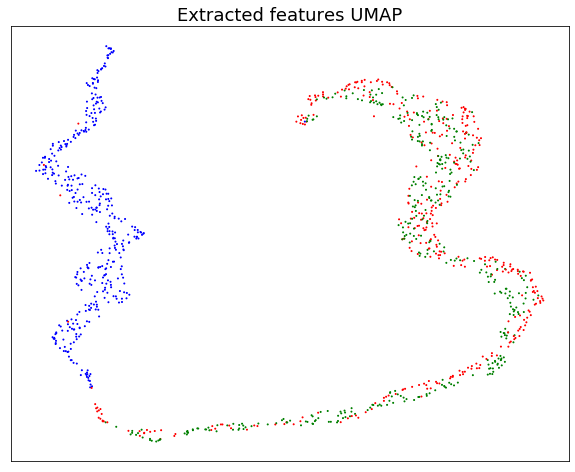

In [80]:
features = emb_Pad

embed = umap.UMAP(n_neighbors=10,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_Pad,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features UMAP", fontsize=18)

plt.show()


### Task B (IMS)

In [81]:
emb_IMS = np.nan_to_num(embedding(X_test_IMS))

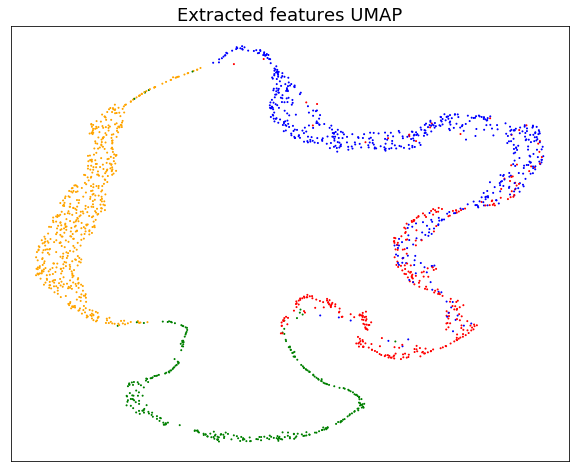

In [82]:
features = emb_IMS

embed = umap.UMAP(n_neighbors=10,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_IMS,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features UMAP", fontsize=18)

plt.show()


Finally, we show the code to load the weights of the model (for predictions or retrainig)